In [10]:
# Importing necessary libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnetpreprocess
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

In [2]:
# Data directory paths
main_dir = r'C:\Users\Keerthi Devireddy\Downloads\Big Data and Machine Learning Mini Project\Vegetable Images'
train_dir = os.path.join(main_dir, 'train')
val_dir = os.path.join(main_dir, 'validation')
test_dir = os.path.join(main_dir, 'test')

In [3]:
# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 5000 images belonging to 10 classes.
Found 750 images belonging to 10 classes.
Found 750 images belonging to 10 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


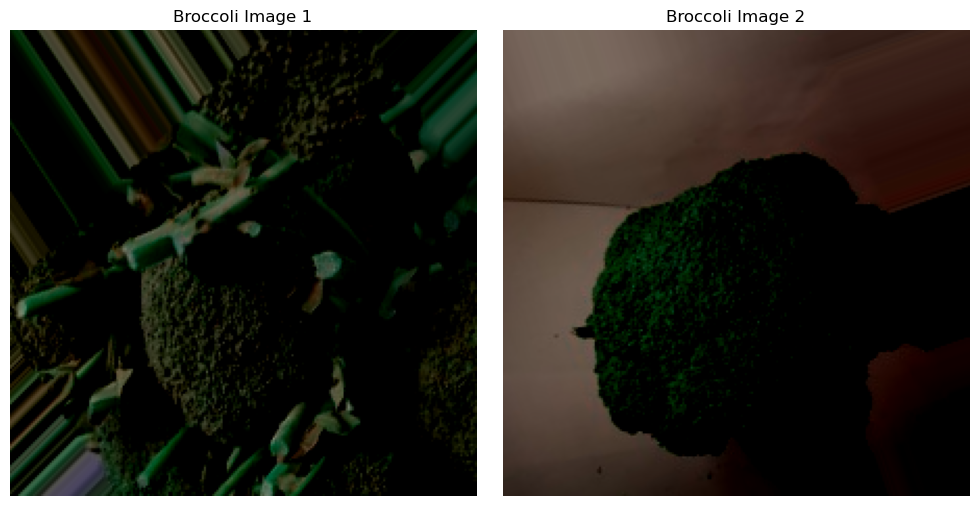

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


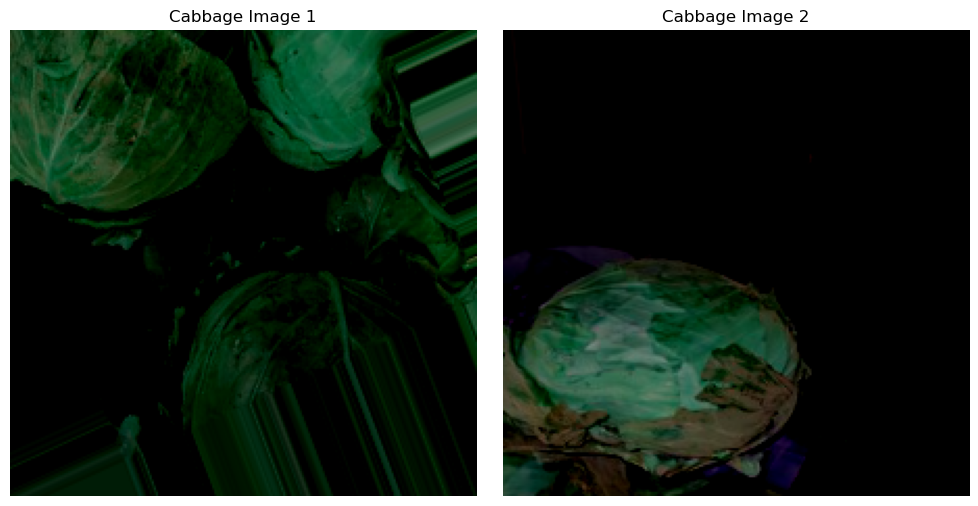

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


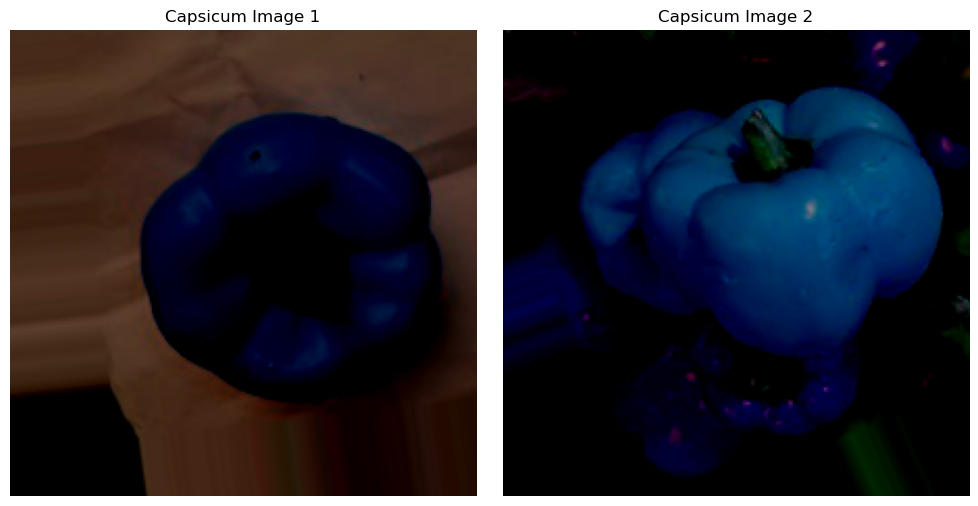

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


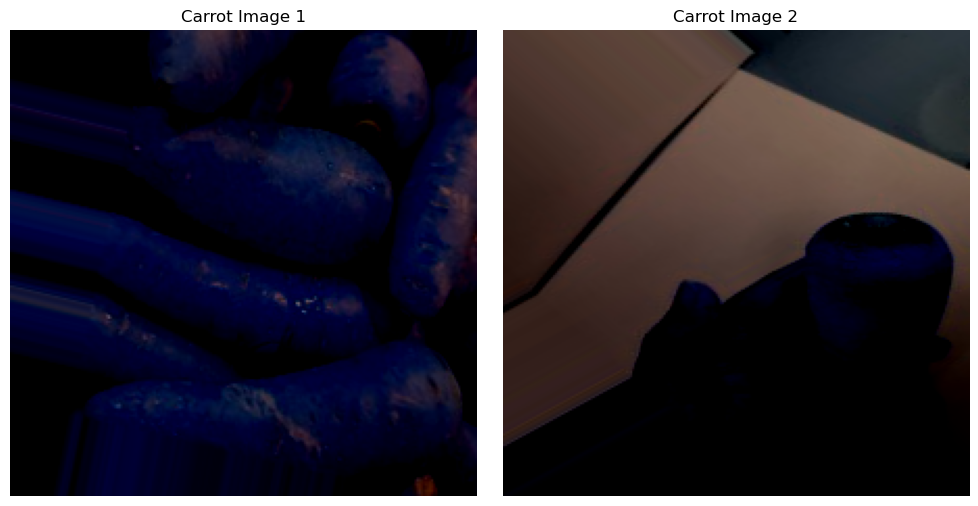

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


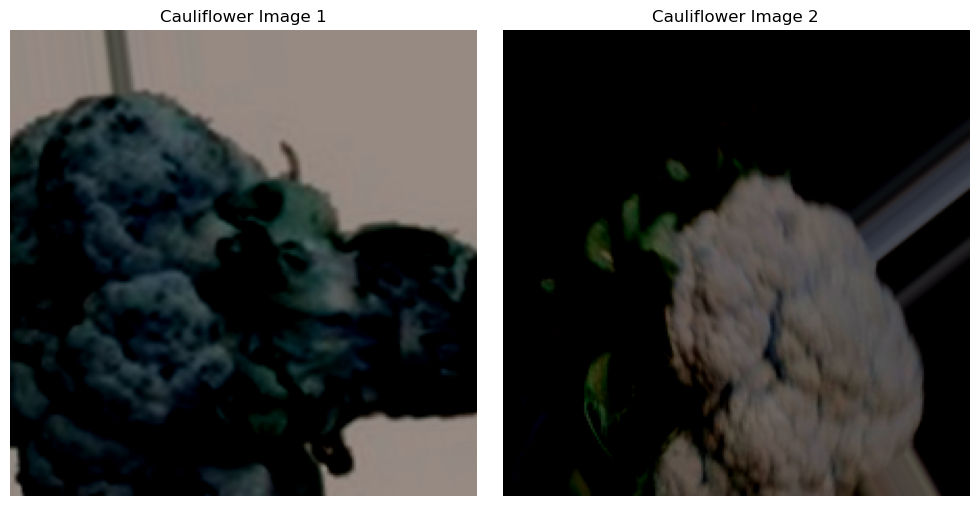

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


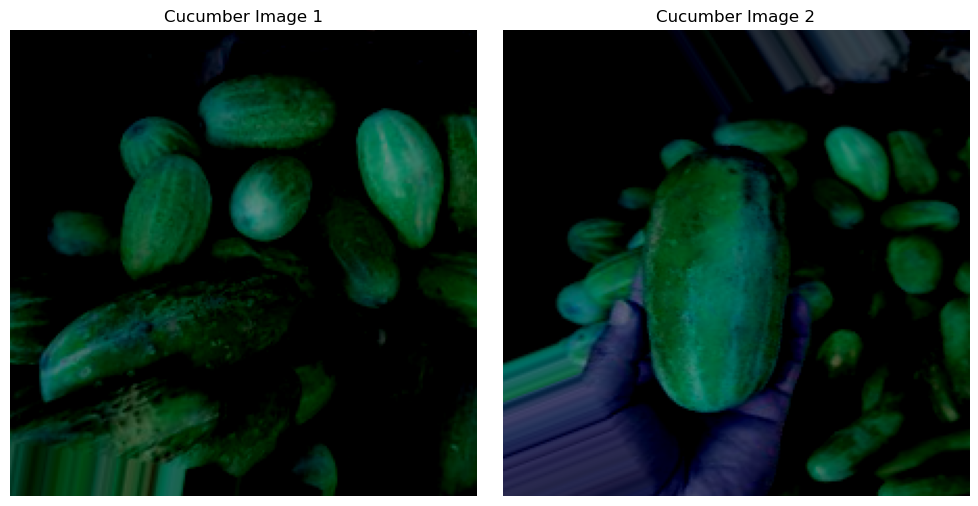

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


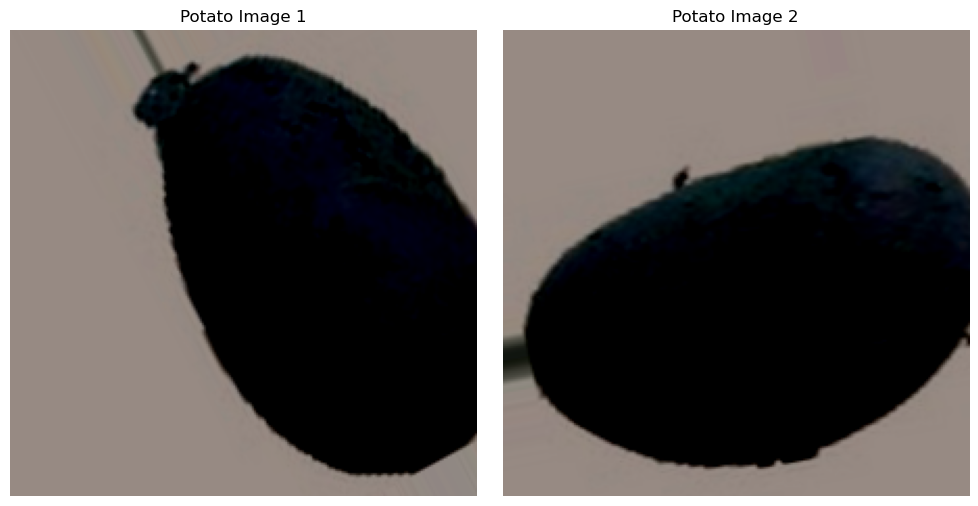

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


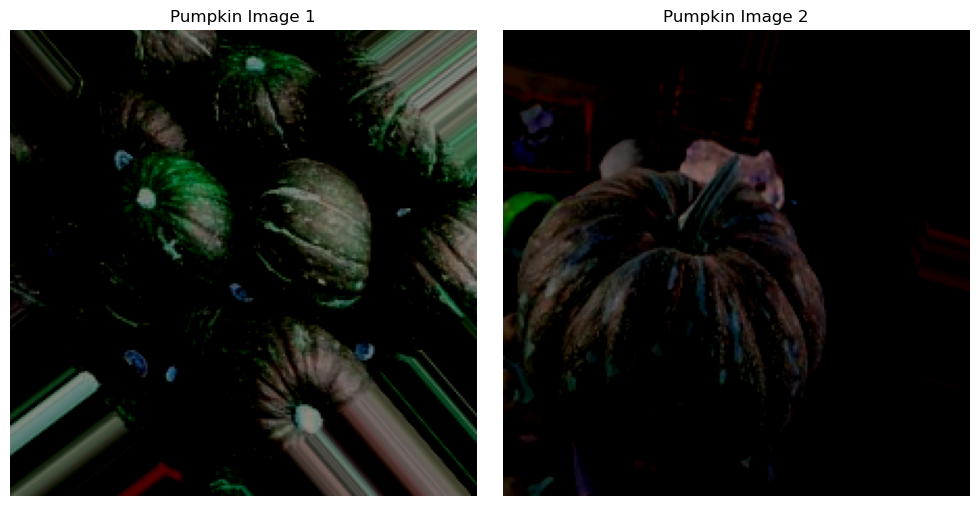

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


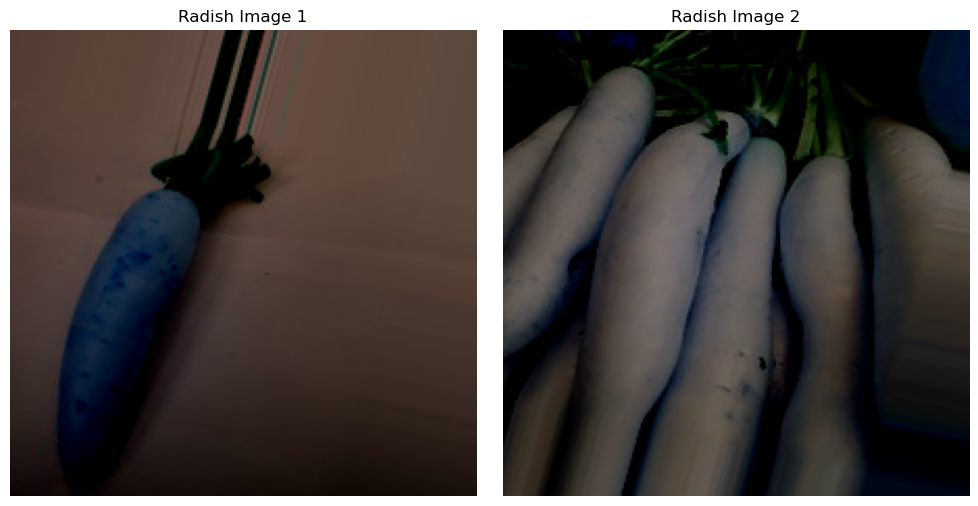

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


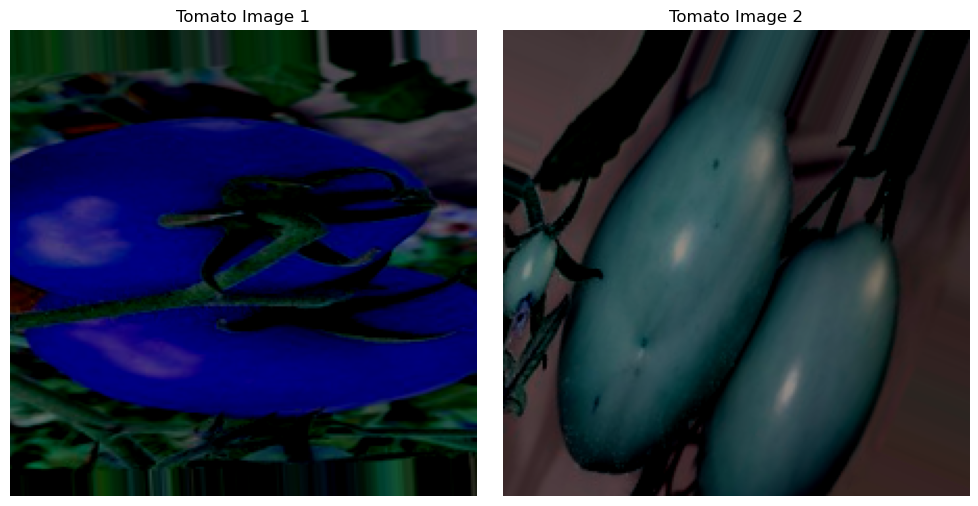

In [8]:
# Function to display up to two images for each category
def display_images_per_category(generator, categories):
    num_images_per_category = 2 
    
    # Iterating over each category
    for category in categories:
        # Retrieving images and labels for the current category
        images, labels = next(generator)
        category_labels = [list(generator.class_indices.keys())[np.argmax(label)] for label in labels]
        indices = [i for i, label in enumerate(category_labels) if label == category]
        
        # Filtering images for the current category
        selected_indices = indices[:num_images_per_category]
        selected_images = [images[idx] / 255.0 for idx in selected_indices]  
        
        # Plotting the selected images for the current category
        if selected_images:
            plt.figure(figsize=(10, 5))
            for i, image in enumerate(selected_images):
                plt.subplot(1, num_images_per_category, i + 1)
                plt.imshow(image)
                plt.title(f'{category} Image {i + 1}')
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"No images found for category '{category}'")

# Displaying up to two images for each category
display_images_per_category(train_generator, categories)


In [4]:
# Building the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the base model layers
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Custom callback for displaying training progress
class ProgressCallback(Callback):
    def on_batch_end(self, batch, logs=None):
        current_batch = batch + 1
        total_batches = len(train_generator)
        progress = current_batch / total_batches * 100
        print(f'\rTraining progress: {progress:.2f}%', end='')

# Defining callbacks for early stopping, learning rate reduction, and progress display
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
progress_callback = ProgressCallback()

# Training the model
epochs = 15
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator,
                    callbacks=[early_stopping, reduce_lr, progress_callback])

Epoch 1/15


C:\Users\Keerthi Devireddy\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 964s 6s/step - accuracy: 0.4188 - loss: 16.9185 - val_accuracy: 0.9653 - val_loss: 0.9187 - learning_rate: 0.0010
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 954s 6s/step - accuracy: 0.6329 - loss: 2.1936 - val_accuracy: 0.9720 - val_loss: 0.9127 - learning_rate: 0.0010
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 969s 6s/step - accuracy: 0.7492 - loss: 1.7633 - val_accuracy: 0.9840 - val_loss: 0.8063 - learning_rate: 0.0010
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 980s 6s/step - accuracy: 0.7831 - loss: 1.6382 - val_accuracy: 0.9827 - val_loss: 0.8169 - learning_rate: 0.0010
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 804s 5s/step - accuracy: 0.7840 - loss: 1.5190 - val_accuracy: 0.9840 - val_loss: 0.7945 - learning_rate: 0.0010
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 889s 6s/step - accuracy: 0.8247 - loss: 1.3150 - val_accuracy: 0.9827 - val_loss: 0.8224 - learning_rate: 0.0010
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 787s 5s/step - accuracy: 0.7533 - loss: 1.6301 - val

24/24 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.9718 - loss: 0.7890



Test Loss: 0.795928418636322, Test Accuracy: 97.47%


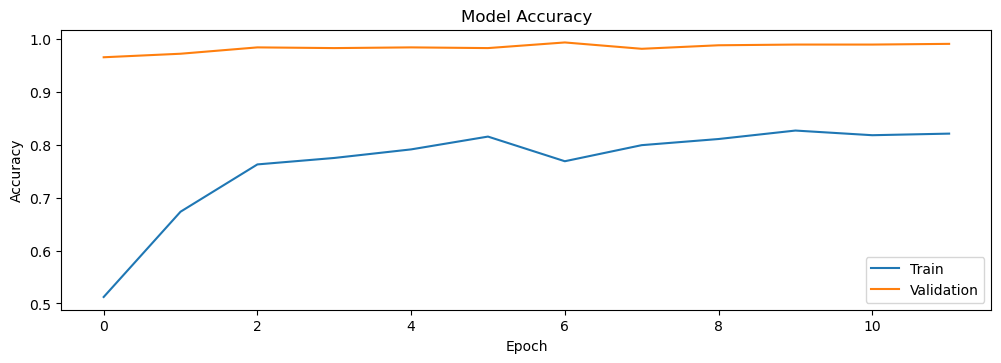

In [5]:
# Saving the trained model
model.save('vgg16_model.h5')

# Plotting the training and validation accuracy curves
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

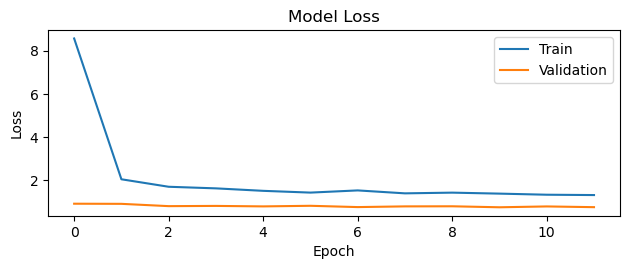

In [6]:
# Plotting the training and validation loss curves
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [15]:
retrained_model = load_model(r'C:\Users\Keerthi Devireddy\Downloads\Big Data and Machine Learning Mini Project\vgg16_model.h5')
print(retrained_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,171,660 (80.76 MB)

 Trainable params: 21,171,658 (80.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [13]:
# Testing the model on few images from the test data
test_images, test_labels = next(test_generator)
predictions = model.predict(test_images)
class_names = test_generator.class_indices
class_names = {v: k for k, v in class_names.items()}

for i in range(30):
    image_index = i
    predicted_class = np.argmax(predictions[image_index])
    predicted_label = class_names[predicted_class]
    actual_label = class_names[np.argmax(test_labels[image_index])]
    print(f"Image {image_index + 1}: Actual Label: {actual_label}, Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Image 1: Actual Label: Capsicum, Predicted Label: Capsicum
Image 2: Actual Label: Pumpkin, Predicted Label: Pumpkin
Image 3: Actual Label: Radish, Predicted Label: Radish
Image 4: Actual Label: Carrot, Predicted Label: Carrot
Image 5: Actual Label: Radish, Predicted Label: Radish
Image 6: Actual Label: Radish, Predicted Label: Radish
Image 7: Actual Label: Tomato, Predicted Label: Tomato
Image 8: Actual Label: Radish, Predicted Label: Radish
Image 9: Actual Label: Cucumber, Predicted Label: Cucumber
Image 10: Actual Label: Broccoli, Predicted Label: Broccoli
Image 11: Actual Label: Potato, Predicted Label: Potato
Image 12: Actual Label: Cabbage, Predicted Label: Cabbage
Image 13: Actual Label: Broccoli, Predicted Label: Broccoli
Image 14: Actual Label: Tomato, Predicted Label: Tomato
Image 15: Actual Label: Carrot, Predicted Label: Carrot
Image 16: Actual Label: Cabbage, Predicted Label: Cabbage
Image 17: Actual Label: Potato, Predicted Label: Potato

In [3]:
# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=resnetpreprocess,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=resnetpreprocess)
test_datagen = ImageDataGenerator(preprocessing_function=resnetpreprocess)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 5000 images belonging to 10 classes.
Found 750 images belonging to 10 classes.
Found 750 images belonging to 10 classes.


In [4]:
# Building the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the base model layers
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Custom callback for displaying training progress
class ProgressCallback(Callback):
    def on_batch_end(self, batch, logs=None):
        current_batch = batch + 1
        total_batches = len(train_generator)
        progress = current_batch / total_batches * 100
        print(f'\rTraining progress: {progress:.2f}%', end='')

# Defining callbacks for early stopping, learning rate reduction, and progress display
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
progress_callback = ProgressCallback()

# Training the model
epochs = 15
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator,
                    callbacks=[early_stopping, reduce_lr, progress_callback])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/15


C:\Users\Keerthi Devireddy\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.3994 - loss: 10.1546 - val_accuracy: 0.9773 - val_loss: 1.3075 - learning_rate: 0.0010
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.6814 - loss: 2.4807 - val_accuracy: 0.9827 - val_loss: 1.2087 - learning_rate: 0.0010
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.7821 - loss: 1.9485 - val_accuracy: 0.9893 - val_loss: 1.1215 - learning_rate: 0.0010
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.8448 - loss: 1.7002 - val_accuracy: 0.9907 - val_loss: 1.0922 - learning_rate: 0.0010
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.8585 - loss: 1.6567 - val_accuracy: 0.9893 - val_loss: 1.0944 - learning_rate: 0.0010
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.8424 - loss: 1.8342 - val_accuracy: 0.9973 - val_loss: 1.1461 - learning_rate: 0.0010
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.8681 - loss: 1.6430 - val

In [5]:
# Evaluating the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f'\nTest Loss: {loss}, Test Accuracy: {accuracy * 100:.2f}%')

# Saving the trained model
model.save('resnet_model.h5')

24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9982 - loss: 0.9757



Test Loss: 0.9862627983093262, Test Accuracy: 99.73%


In [14]:
retrained_model = load_model(r'C:\Users\Keerthi Devireddy\Downloads\Big Data and Machine Learning Mini Project\resnet_model.h5')
print(retrained_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 49,312,268 (188.11 MB)

 Trainable params: 49,259,146 (187.91 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

None


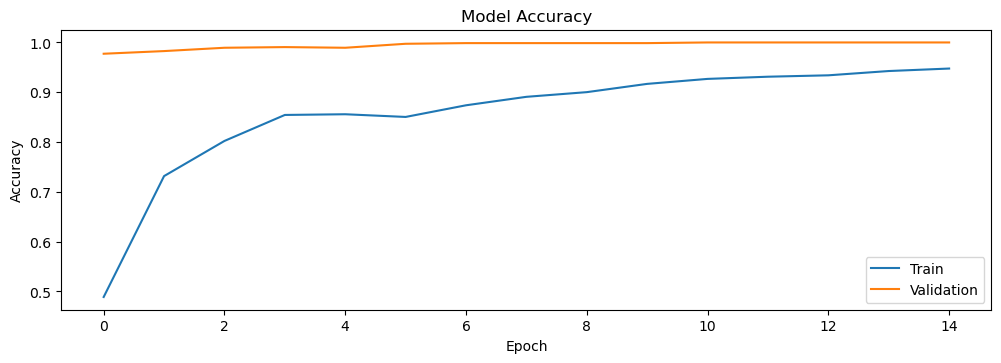

In [6]:
# Plotting the training and validation accuracy curves
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

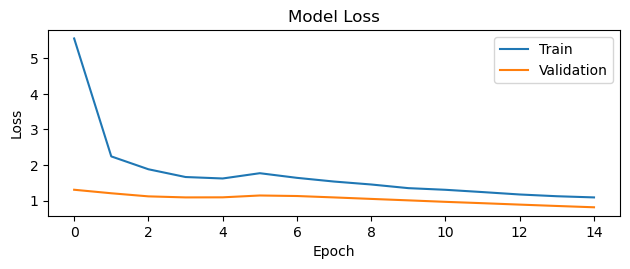

In [7]:
# Plotting the training and validation loss curves
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [8]:
# Testing the model on few images from the test data
test_images, test_labels = next(test_generator)
predictions = model.predict(test_images)
class_names = test_generator.class_indices
class_names = {v: k for k, v in class_names.items()}

for i in range(30):
    image_index = i
    predicted_class = np.argmax(predictions[image_index])
    predicted_label = class_names[predicted_class]
    actual_label = class_names[np.argmax(test_labels[image_index])]
    print(f"Image {image_index + 1}: Actual Label: {actual_label}, Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Image 1: Actual Label: Radish, Predicted Label: Radish
Image 2: Actual Label: Cucumber, Predicted Label: Cucumber
Image 3: Actual Label: Cucumber, Predicted Label: Cucumber
Image 4: Actual Label: Tomato, Predicted Label: Tomato
Image 5: Actual Label: Cauliflower, Predicted Label: Cauliflower
Image 6: Actual Label: Radish, Predicted Label: Radish
Image 7: Actual Label: Pumpkin, Predicted Label: Pumpkin
Image 8: Actual Label: Radish, Predicted Label: Radish
Image 9: Actual Label: Tomato, Predicted Label: Tomato
Image 10: Actual Label: Pumpkin, Predicted Label: Pumpkin
Image 11: Actual Label: Tomato, Predicted Label: Tomato
Image 12: Actual Label: Carrot, Predicted Label: Carrot
Image 13: Actual Label: Broccoli, Predicted Label: Broccoli
Image 14: Actual Label: Radish, Predicted Label: Radish
Image 15: Actual Label: Cauliflower, Predicted Label: Cauliflower
Image 16: Actual Label: Cauliflower, Predicted Label: Cauliflower
Image 17: Actual Label: Broccol